In [52]:
# Import Libraries
# import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from scipy.sparse import csr_matrix
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error
import itertools
from sklearn.metrics import silhouette_samples, silhouette_score
%matplotlib inline
# Import the Movies dataset
movies = pd.read_csv('https://gist.githubusercontent.com/dhruvt11/74081e013747b573295fdae5f9cd8e4c/raw/d7ef4224ddaf7f7f44d8e12b5b88381212c62bbc/movies.csv')
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [3]:
!pip install pandas==1.5.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import pandas as pd
pd.__version__

'1.5.2'

In [5]:
# Import the ratings dataset
ratings = pd.read_csv('https://gist.githubusercontent.com/dhruvt11/7bb0b73f7bd9af37c67c1ed12e919846/raw/6311a023bc1a3d6da1ad963fe04de4b4320ad5ac/ratings.csv')
ratings.head()


,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [6]:
# Print the number of records and the total number of movies
print('The dataset contains: ', len(ratings), ' ratings of ', len(movies), ' movies.')

The dataset contains:  100836  ratings of  9742  movies.


In [7]:
# Function to get the genre ratings
def get_genre_ratings(ratings, movies, genres, column_names):
    genre_ratings = pd.DataFrame()
    for genre in genres:        
        genre_movies = movies[movies['genres'].str.contains(genre) ]
        avg_genre_votes_per_user = ratings[ratings['movieId'].isin(genre_movies['movieId'])].loc[:, ['userId', 'rating']].groupby(['userId'])['rating'].mean().round(2)
        
        genre_ratings = pd.concat([genre_ratings, avg_genre_votes_per_user], axis=1)
        
    genre_ratings.columns = column_names
    return genre_ratings
# Calculate the average rating of romance and scifi movies
genre_ratings = get_genre_ratings(ratings, movies, ['Romance', 'Sci-Fi'], ['avg_romance_rating', 'avg_scifi_rating'])
genre_ratings.head()

,avg_romance_rating,avg_scifi_rating
1,4.31,4.22
2,4.50,3.88
3,0.50,4.20
4,3.38,2.83
5,3.09,2.50


In [8]:
# Function to get the biased dataset
def bias_genre_rating_dataset(genre_ratings, score_limit_1, score_limit_2):
    biased_dataset =    genre_ratings[((genre_ratings['avg_romance_rating'] < score_limit_1 - 0.2) & (genre_ratings['avg_scifi_rating'] > score_limit_2)) | ((genre_ratings['avg_scifi_rating'] < score_limit_1) & (genre_ratings['avg_romance_rating'] > score_limit_2))]
    biased_dataset = pd.concat([biased_dataset[:300], genre_ratings[:2]])
    biased_dataset = pd.DataFrame(biased_dataset.to_records())
    return biased_dataset
# Bias the dataset
biased_dataset = bias_genre_rating_dataset(genre_ratings, 3.2, 2.5)
# Printing the resulting number of records & the head of the dataset
print( "Number of records: ", len(biased_dataset))
biased_dataset.head()

Number of records:  162


,index,avg_romance_rating,avg_scifi_rating
0,3,0.50,4.20
1,4,3.38,2.83
2,5,3.09,2.50
3,7,2.65,3.15
4,9,3.17,3.00


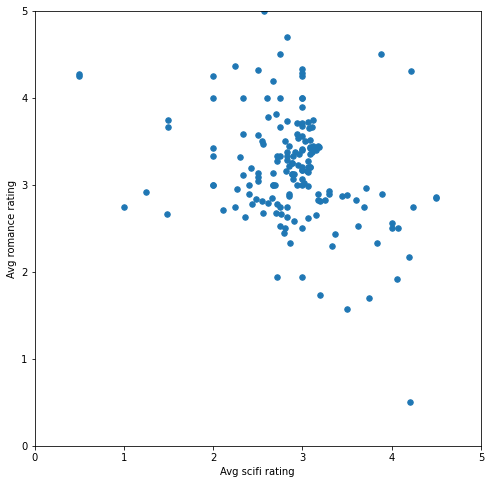

In [9]:
# Defining the scatterplot drawing function
def draw_scatterplot(x_data, x_label, y_data, y_label):
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    plt.xlim(0, 5)
    plt.ylim(0, 5)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.scatter(x_data, y_data, s=30)
# Plot the scatterplot
draw_scatterplot(biased_dataset['avg_scifi_rating'],'Avg scifi rating', biased_dataset['avg_romance_rating'], 'Avg romance rating')

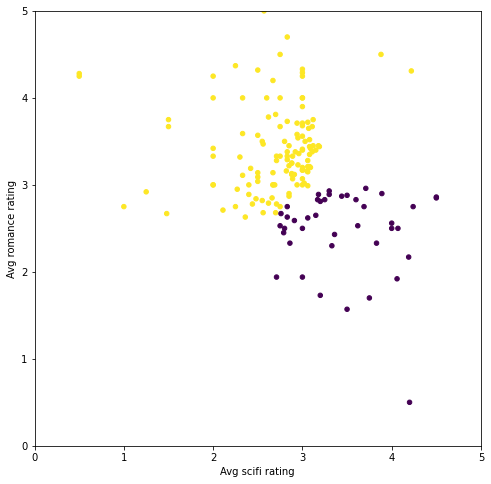

In [10]:
# Let's turn our dataset into a list
X = biased_dataset[['avg_scifi_rating','avg_romance_rating']].values
# Import KMeans
from sklearn.cluster import KMeans
# Create an instance of KMeans to find two clusters
kmeans_1 = KMeans(n_clusters=2)
# Use fit_predict to cluster the dataset
predictions = kmeans_1.fit_predict(X)
# Defining the cluster plotting function
def draw_clusters(biased_dataset, predictions, cmap='viridis'):
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    plt.xlim(0, 5)
    plt.ylim(0, 5)
    ax.set_xlabel('Avg scifi rating')
    ax.set_ylabel('Avg romance rating')
    clustered = pd.concat([biased_dataset.reset_index(), pd.DataFrame({'group':predictions})], axis=1)
    plt.scatter(clustered['avg_scifi_rating'], clustered['avg_romance_rating'], c=clustered['group'], s=20,cmap='viridis')
# Plot
draw_clusters(biased_dataset, predictions)

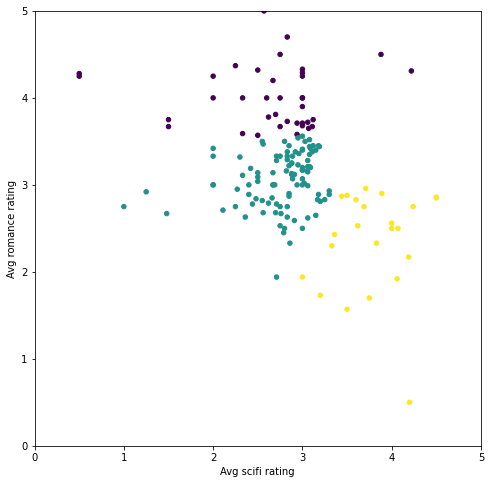

In [11]:
# Create an instance of KMeans to find three clusters
kmeans_2 = KMeans(n_clusters=3)
# Use fit_predict to cluster the dataset
predictions_2 = kmeans_2.fit_predict(X)
# Plot
draw_clusters(biased_dataset, predictions_2)

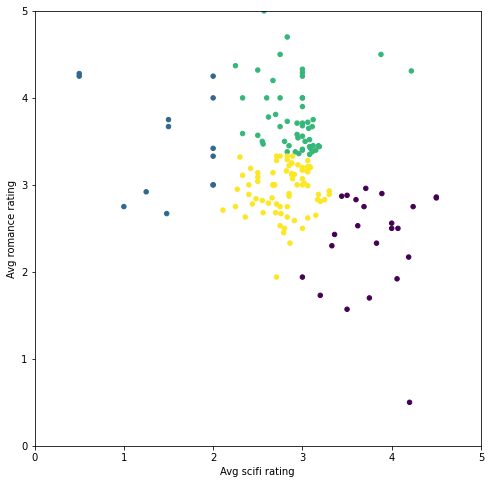

In [12]:
# Create an instance of KMeans to find three clusters
kmeans_3 = KMeans(n_clusters=4)
# Use fit_predict to cluster the dataset
predictions_3 = kmeans_3.fit_predict(X)
# Plot
draw_clusters(biased_dataset, predictions_3)

In [26]:
# Choose the range of k values to test.
# We added a stride of 5 to improve performance. We don't need to calculate the error for every k value
possible_k_values = range(2, len(X)+1, 5)

# Calculate error values for all k values we're interested in
errors_per_k = [clustering_errors(k, X) for k in possible_k_values]
list(zip(possible_k_values, errors_per_k))

<ipython-input-18-343bd60227fd>:8: ConvergenceWarning: Number of distinct clusters (157) found smaller than n_clusters (162). Possibly due to duplicate points in X.
  kmeans = KMeans(n_clusters=k).fit(data)


[(2, 0.37651376343962917),
 (7, 0.3497101830214605),
 (12, 0.39420672006047386),
 (17, 0.36706027906487687),
 (22, 0.3733635890677534),
 (27, 0.41195130278802544),
 (32, 0.4228326108752129),
 (37, 0.4400069208409186),
 (42, 0.4187673364439478),
 (47, 0.41477409175304863),
 (52, 0.4195222179560817),
 (57, 0.4031278546866071),
 (62, 0.4177642471910276),
 (67, 0.40181842583706295),
 (72, 0.3884758791362967),
 (77, 0.387333955956263),
 (82, 0.3716780176316528),
 (87, 0.3599057352709708),
 (92, 0.33704607179311924),
 (97, 0.3219298660237455),
 (102, 0.30088015987766814),
 (107, 0.29662876454101567),
 (112, 0.2699324133673212),
 (117, 0.2746891456597509),
 (122, 0.24026670672288733),
 (127, 0.22208385267878802),
 (132, 0.21063694019217982),
 (137, 0.19485533237237704),
 (142, 0.1745705045298946),
 (147, 0.13831784871757571),
 (152, 0.10678588096581217),
 (157, 0.06172839506172839),
 (162, 0.06172839506172839)]

<ipython-input-18-343bd60227fd>:8: ConvergenceWarning: Number of distinct clusters (157) found smaller than n_clusters (162). Possibly due to duplicate points in X.
  kmeans = KMeans(n_clusters=k).fit(data)


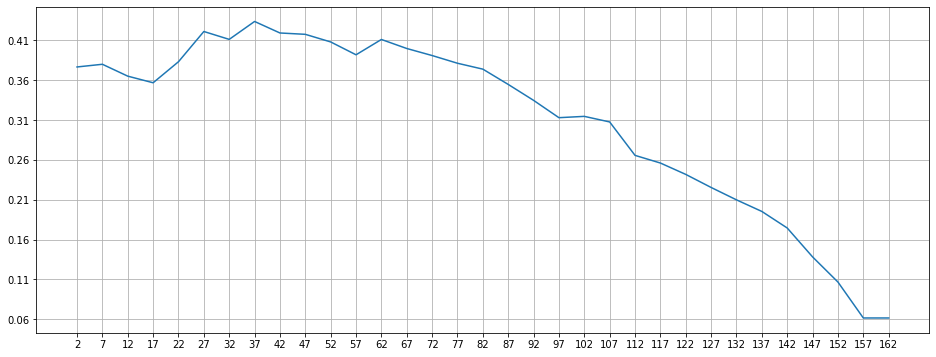

In [18]:
# Selecting our dataset to study
df = biased_dataset[['avg_scifi_rating','avg_romance_rating']]
# Choose the range of k values to test.
# We added a stride of 5 to improve performance. We don't need to calculate the error for every k value
possible_k_values = range(2, len(X)+1, 5)
# Define function to calculate the clustering errors
def clustering_errors(k, data):
    kmeans = KMeans(n_clusters=k).fit(data)
    predictions = kmeans.predict(data)
    #cluster_centers = kmeans.cluster_centers_
    # errors = [mean_squared_error(row, cluster_centers[cluster]) for row, cluster in zip(data.values, predictions)]
    # return sum(errors)
    silhouette_avg = silhouette_score(data, predictions)
    return silhouette_avg
# Calculate error values for all k values we're interested in
errors_per_k = [clustering_errors(k, X) for k in possible_k_values]
# Plot the each value of K vs. the silhouette score at that value
fig, ax = plt.subplots(figsize=(16, 6))
plt.plot(possible_k_values, errors_per_k)
# Ticks and grid
xticks = np.arange(min(possible_k_values), max(possible_k_values)+1, 5.0)
ax.set_xticks(xticks, minor=False)
ax.set_xticks(xticks, minor=True)
ax.xaxis.grid(True, which='both')
yticks = np.arange(round(min(errors_per_k), 2), max(errors_per_k), .05)
ax.set_yticks(yticks, minor=False)
ax.set_yticks(yticks, minor=True)
ax.yaxis.grid(True, which='both')

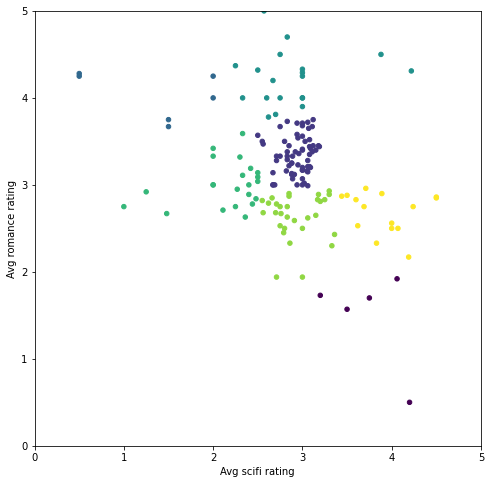

In [19]:
# Create an instance of KMeans to find seven clusters
kmeans_4 = KMeans(n_clusters=7)
# Use fit_predict to cluster the dataset
predictions_4 = kmeans_4.fit_predict(X)
# Plot
draw_clusters(biased_dataset, predictions_4, cmap='Accent')

In [20]:
# Select our biased dataset and add action genre
biased_dataset_3_genres = get_genre_ratings(ratings, movies, ['Romance','Sci-Fi', 'Action'],                                          
['avg_romance_rating', 'avg_scifi_rating', 'avg_action_rating'])
# Drop null values
biased_dataset_3_genres = bias_genre_rating_dataset(biased_dataset_3_genres, 3.2, 2.5).dropna()
# Print the number of records and the head of our dataset
print( "Number of records: ", len(biased_dataset_3_genres))
biased_dataset_3_genres.head()

Number of records:  161


,index,avg_romance_rating,avg_scifi_rating,avg_action_rating
0,3,0.50,4.20,3.57
1,4,3.38,2.83,3.32
2,5,3.09,2.50,3.11
3,7,2.65,3.15,3.26
4,9,3.17,3.00,3.12


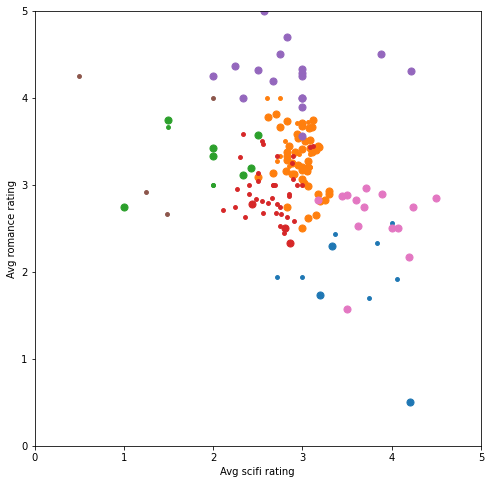

In [21]:
# Turn dataset into a list
X_with_action = biased_dataset_3_genres[['avg_scifi_rating',                                                   'avg_romance_rating',                                                         'avg_action_rating']].values
# Create an instance of KMeans to find seven clusters
kmeans_5 = KMeans(n_clusters=7)
# Use fit_predict to cluster the dataset
predictions_5 = kmeans_5.fit_predict(X_with_action)
# Define 3d plotting function
def draw_clusters_3d(biased_dataset_3, predictions):
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    plt.xlim(0, 5)
    plt.ylim(0, 5)
    ax.set_xlabel('Avg scifi rating')
    ax.set_ylabel('Avg romance rating')
    clustered = pd.concat([biased_dataset_3.reset_index(), pd.DataFrame({'group':predictions})], axis=1)
    colors = itertools.cycle(plt.rcParams["axes.prop_cycle"].by_key()["color"])
    for g in clustered.group.unique():
        color = next(colors)
        for index, point in clustered[clustered.group == g].iterrows():
            if point['avg_action_rating'].astype(float) > 3: 
                size = 50
            else:
                size = 15
            plt.scatter(point['avg_scifi_rating'], 
                        point['avg_romance_rating'], 
                        s=size, 
                        color=color)
# Plot
draw_clusters_3d(biased_dataset_3_genres, predictions_5)

In [22]:
# Merge the two tables then pivot so we have Users X Movies dataframe
ratings_title = pd.merge(ratings, movies[['movieId', 'title']], on='movieId' )
user_movie_ratings = pd.pivot_table(ratings_title, index='userId', columns= 'title', values='rating')
# Print he number of dimensions and a subset of the dataset
print('dataset dimensions: ', user_movie_ratings.shape, '\n\nSubset example:')
user_movie_ratings.iloc[:6, :10]

dataset dimensions:  (610, 9719) 

Subset example:


title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987)
userId,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [30]:
def get_most_rated_movies(user_movie_ratings, max_number_of_movies):
    # 1- Count
    user_movie_ratings = user_movie_ratings.append(user_movie_ratings.count(), ignore_index=True)
    # 2- sort
    user_movie_ratings_sorted = user_movie_ratings.sort_values(len(user_movie_ratings)-1, axis=1, ascending=False)
    user_movie_ratings_sorted = user_movie_ratings_sorted.drop(user_movie_ratings_sorted.tail(1).index)
    # 3- slice
    most_rated_movies = user_movie_ratings_sorted.iloc[:, :max_number_of_movies]
    return most_rated_movies

In [46]:
def get_users_who_rate_the_most(most_rated_movies, max_number_of_movies):
    # Get most voting users
    # 1- Count
    most_rated_movies['counts'] = pd.Series(most_rated_movies.count(axis=1))
    # 2- Sort
    most_rated_movies_users = most_rated_movies.sort_values('counts', ascending=False)
    # 3- Slice
    most_rated_movies_users_selection = most_rated_movies_users.iloc[:max_number_of_movies, :]
    most_rated_movies_users_selection = most_rated_movies_users_selection.drop(['counts'], axis=1)
    return most_rated_movies_users_selection

In [32]:
def sort_by_rating_density(user_movie_ratings, n_movies, n_users):
    most_rated_movies = get_most_rated_movies(user_movie_ratings, n_movies)
    most_rated_movies = get_users_who_rate_the_most(most_rated_movies, n_users)
    return most_rated_movies

In [47]:
n_movies = 30
n_users = 18
most_rated_movies_users_selection = sort_by_rating_density(user_movie_ratings, n_movies, n_users)
most_rated_movies_users_selection.head()

<ipython-input-30-4eec43b52166>:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  user_movie_ratings = user_movie_ratings.append(user_movie_ratings.count(), ignore_index=True)


title,Forrest Gump (1994),"Shawshank Redemption, The (1994)",Pulp Fiction (1994),"Silence of the Lambs, The (1991)","Matrix, The (1999)",Star Wars: Episode IV - A New Hope (1977),Jurassic Park (1993),Braveheart (1995),Terminator 2: Judgment Day (1991),Schindler's List (1993),...,Star Wars: Episode VI - Return of the Jedi (1983),"Godfather, The (1972)","Fugitive, The (1993)",Batman (1989),Saving Private Ryan (1998),"Lord of the Rings: The Two Towers, The (2002)","Lord of the Rings: The Return of the King, The (2003)",Aladdin (1992),Fargo (1996),"Sixth Sense, The (1999)"
413,5.0,5.0,5.0,4.0,5.0,5.0,4.0,5.0,5.0,4.0,...,5.0,5.0,5.0,4.0,5.0,5.0,4.0,4.0,5.0,3.0
589,5.0,4.5,4.5,3.5,4.0,5.0,4.0,4.0,4.5,5.0,...,4.5,5.0,4.0,3.5,4.0,5.0,4.5,4.0,4.0,3.5
473,3.0,5.0,4.0,4.5,4.5,4.0,4.5,3.0,4.0,5.0,...,4.0,5.0,5.0,4.0,3.0,5.0,5.0,4.0,4.0,5.0
479,5.0,5.0,4.0,4.5,5.0,4.5,5.0,5.0,4.5,5.0,...,3.5,5.0,3.5,4.5,4.5,4.5,4.0,4.0,4.0,4.0
67,3.5,3.0,2.0,3.5,4.5,5.0,3.5,2.5,3.5,4.0,...,5.0,4.0,4.5,4.0,4.0,4.0,4.5,3.5,2.5,2.5


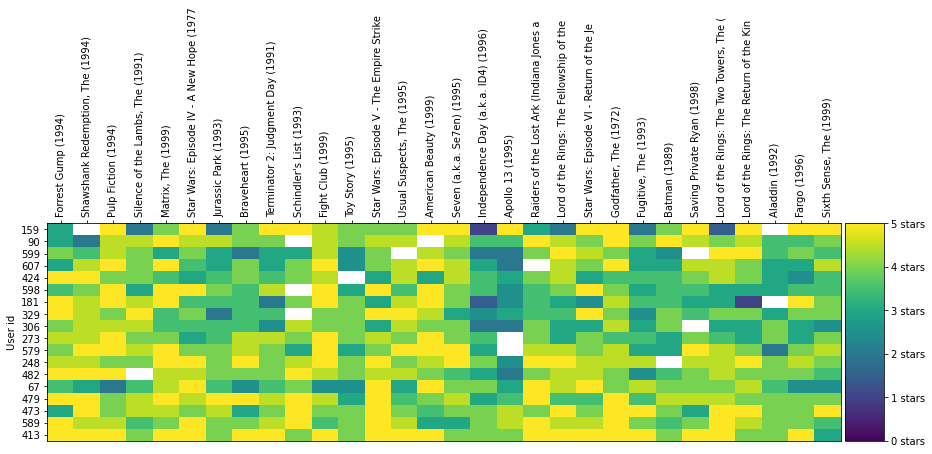

In [48]:
def draw_movies_heatmap(most_rated_movies_users_selection, axis_labels=True):
    
    # Reverse to match the order of the printed dataframe
    #most_rated_movies_users_selection = most_rated_movies_users_selection.iloc[::-1]
    
    fig = plt.figure(figsize=(15,4))
    ax = plt.gca()
    
    # Draw heatmap
    heatmap = ax.imshow(most_rated_movies_users_selection,  interpolation='nearest', vmin=0, vmax=5, aspect='auto')

    if axis_labels:
        ax.set_yticks(np.arange(most_rated_movies_users_selection.shape[0]) , minor=False)
        ax.set_xticks(np.arange(most_rated_movies_users_selection.shape[1]) , minor=False)
        ax.invert_yaxis()
        ax.xaxis.tick_top()
        labels = most_rated_movies_users_selection.columns.str[:40]
        ax.set_xticklabels(labels, minor=False)
        ax.set_yticklabels(most_rated_movies_users_selection.index, minor=False)
        plt.setp(ax.get_xticklabels(), rotation=90)
    else:
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    
    ax.grid(False)
    ax.set_ylabel('User id')

    # Separate heatmap from color bar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)

    # Color bar
    cbar = fig.colorbar(heatmap, ticks=[5, 4, 3, 2, 1, 0], cax=cax)
    cbar.ax.set_yticklabels(['5 stars', '4 stars','3 stars','2 stars','1 stars','0 stars'])



    plt.show()
draw_movies_heatmap(most_rated_movies_users_selection)

In [50]:
user_movie_ratings =  pd.pivot_table(ratings_title, index='userId', columns= 'title', values='rating')
most_rated_movies_1k = get_most_rated_movies(user_movie_ratings, 1000)

<ipython-input-30-4eec43b52166>:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  user_movie_ratings = user_movie_ratings.append(user_movie_ratings.count(), ignore_index=True)


In [60]:
import scipy
from scipy.sparse import csr_matrix

sparse_ratings = csr_matrix(df.astype(pd.SparseDtype("float64",0)).sparse.to_coo())

In [61]:
# 20 clusters
predictions = KMeans(n_clusters=20, algorithm='full').fit_predict(sparse_ratings)

In [67]:
def draw_movie_clusters(clustered, max_users, max_movies):
    c=1
    for cluster_id in clustered.group.unique():
        # To improve visibility, we're showing at most max_users users and max_movies movies per cluster.
        # You can change these values to see more users & movies per cluster
        d = clustered[clustered.group == cluster_id].drop(['index', 'group'], axis=1)
        n_users_in_cluster = d.shape[0]
        
        d = sort_by_rating_density(d, max_movies, max_users)
        
        # d = d.reindex_axis(d.mean().sort_values(ascending=False).index, axis=1)
        # d = d.reindex_axis(d.count(axis=1).sort_values(ascending=False).index)
        d = d.iloc[:max_users, :max_movies]
        n_users_in_plot = d.shape[0]
        
        # We're only selecting to show clusters that have more than 9 users, otherwise, they're less interesting
        if len(d) > 9:
            print('cluster # {}'.format(cluster_id))
            print('# of users in cluster: {}.'.format(n_users_in_cluster), '# of users in plot: {}'.format(n_users_in_plot))
            fig = plt.figure(figsize=(15,4))
            ax = plt.gca()

            ax.invert_yaxis()
            ax.xaxis.tick_top()
            labels = d.columns.str[:40]

            ax.set_yticks(np.arange(d.shape[0]) , minor=False)
            ax.set_xticks(np.arange(d.shape[1]) , minor=False)

            ax.set_xticklabels(labels, minor=False)
                        
            ax.get_yaxis().set_visible(False)

            # Heatmap
            heatmap = plt.imshow(d, vmin=0, vmax=5, aspect='auto')

            ax.set_xlabel('movies')
            ax.set_ylabel('User id')

            divider = make_axes_locatable(ax)
            cax = divider.append_axes("right", size="5%", pad=0.05)

            # Color bar
            cbar = fig.colorbar(heatmap, ticks=[5, 4, 3, 2, 1, 0], cax=cax)
            cbar.ax.set_yticklabels(['5 stars', '4 stars','3 stars','2 stars','1 stars','0 stars'])

            plt.setp(ax.get_xticklabels(), rotation=90, fontsize=9)
            plt.tick_params(axis='both', which='both', bottom='off', top='off', left='off', labelbottom='off', labelleft='off') 
            #print('cluster # {} \n(Showing at most {} users and {} movies)'.format(cluster_id, max_users, max_movies))

            plt.show()


<ipython-input-30-4eec43b52166>:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  user_movie_ratings = user_movie_ratings.append(user_movie_ratings.count(), ignore_index=True)
<ipython-input-30-4eec43b52166>:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  user_movie_ratings = user_movie_ratings.append(user_movie_ratings.count(), ignore_index=True)


cluster # 4.0
# of users in cluster: 32. # of users in plot: 32


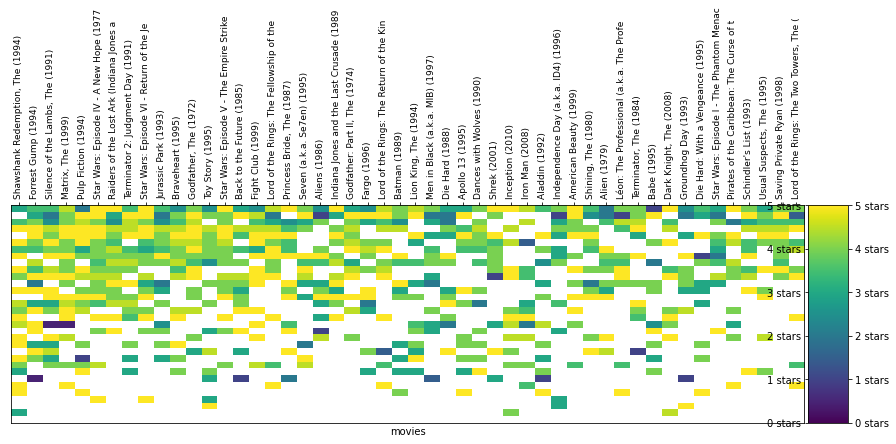

<ipython-input-30-4eec43b52166>:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  user_movie_ratings = user_movie_ratings.append(user_movie_ratings.count(), ignore_index=True)


cluster # 8.0
# of users in cluster: 14. # of users in plot: 14


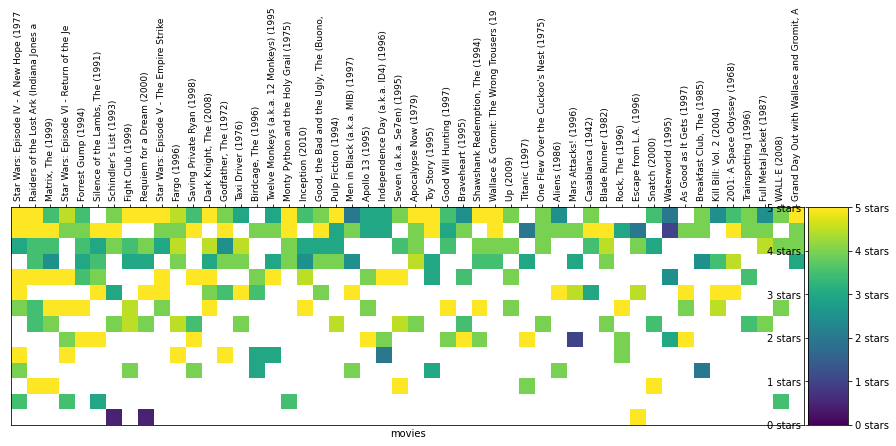

<ipython-input-30-4eec43b52166>:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  user_movie_ratings = user_movie_ratings.append(user_movie_ratings.count(), ignore_index=True)


cluster # 0.0
# of users in cluster: 11. # of users in plot: 11


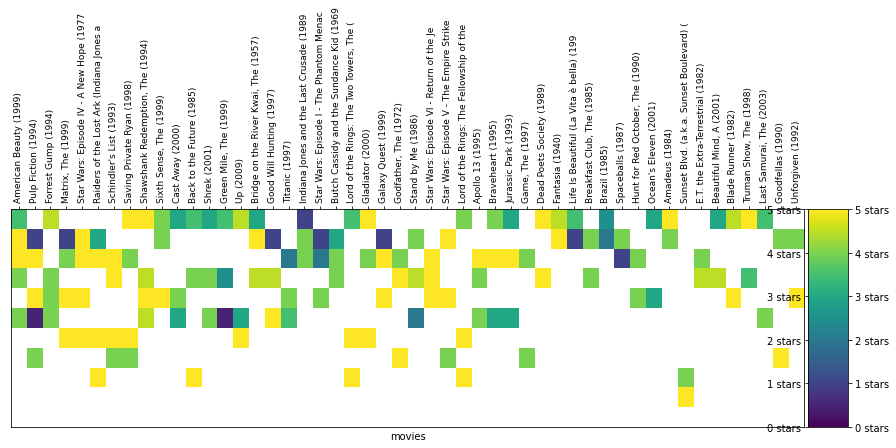

<ipython-input-30-4eec43b52166>:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  user_movie_ratings = user_movie_ratings.append(user_movie_ratings.count(), ignore_index=True)
<ipython-input-30-4eec43b52166>:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  user_movie_ratings = user_movie_ratings.append(user_movie_ratings.count(), ignore_index=True)


cluster # 14.0
# of users in cluster: 17. # of users in plot: 17


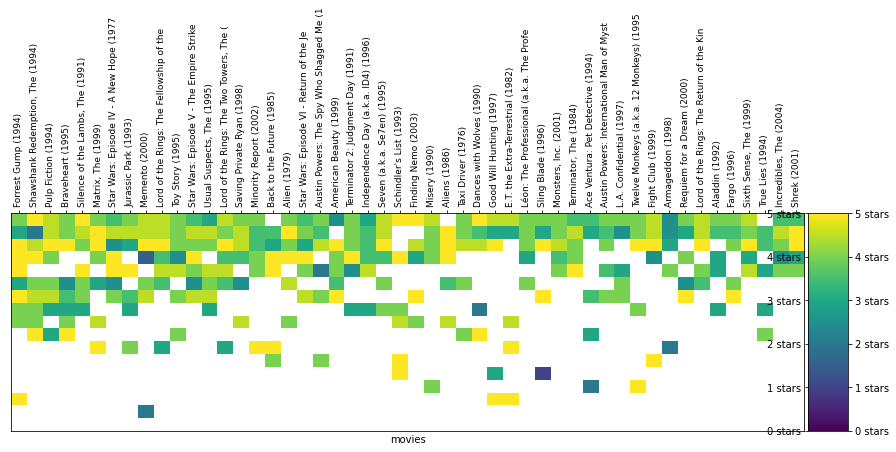

<ipython-input-30-4eec43b52166>:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  user_movie_ratings = user_movie_ratings.append(user_movie_ratings.count(), ignore_index=True)
<ipython-input-30-4eec43b52166>:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  user_movie_ratings = user_movie_ratings.append(user_movie_ratings.count(), ignore_index=True)


cluster # 9.0
# of users in cluster: 23. # of users in plot: 23


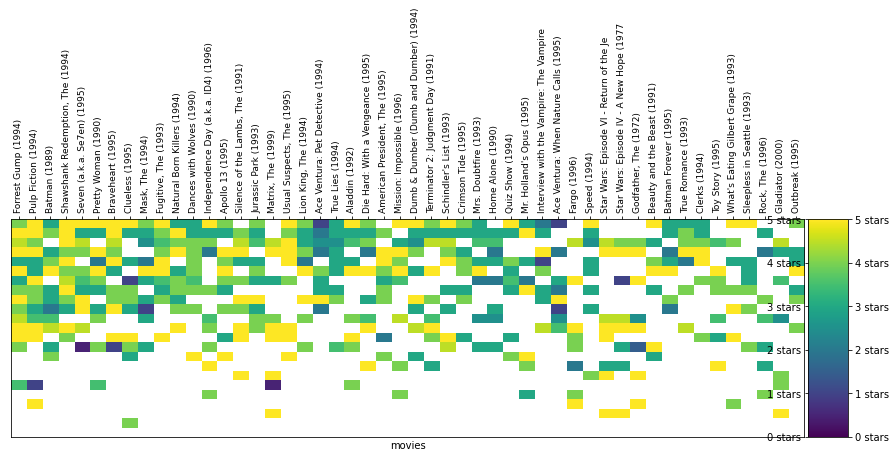

<ipython-input-30-4eec43b52166>:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  user_movie_ratings = user_movie_ratings.append(user_movie_ratings.count(), ignore_index=True)
<ipython-input-30-4eec43b52166>:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  user_movie_ratings = user_movie_ratings.append(user_movie_ratings.count(), ignore_index=True)
<ipython-input-30-4eec43b52166>:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  user_movie_ratings = user_movie_ratings.append(user_movie_ratings.count(), ignore_index=True)
<ipython-input-30-4eec43b52166>:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  user_movie_ratings = user_movie_rating

cluster # 7.0
# of users in cluster: 11. # of users in plot: 11


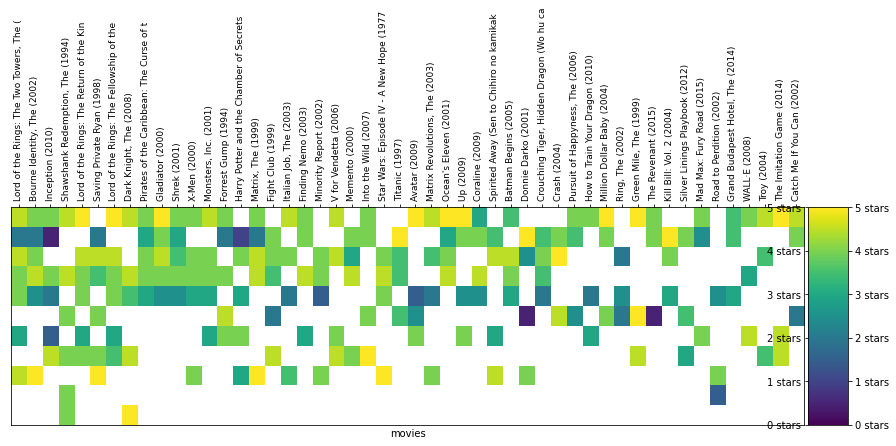

<ipython-input-30-4eec43b52166>:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  user_movie_ratings = user_movie_ratings.append(user_movie_ratings.count(), ignore_index=True)
<ipython-input-30-4eec43b52166>:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  user_movie_ratings = user_movie_ratings.append(user_movie_ratings.count(), ignore_index=True)
<ipython-input-30-4eec43b52166>:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  user_movie_ratings = user_movie_ratings.append(user_movie_ratings.count(), ignore_index=True)
<ipython-input-30-4eec43b52166>:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  user_movie_ratings = user_movie_rating

In [68]:
max_users = 70
max_movies = 50

clustered = pd.concat([most_rated_movies_1k.reset_index(), pd.DataFrame({'group':predictions})], axis=1)
draw_movie_clusters(clustered, max_users, max_movies)

<ipython-input-30-4eec43b52166>:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  user_movie_ratings = user_movie_ratings.append(user_movie_ratings.count(), ignore_index=True)


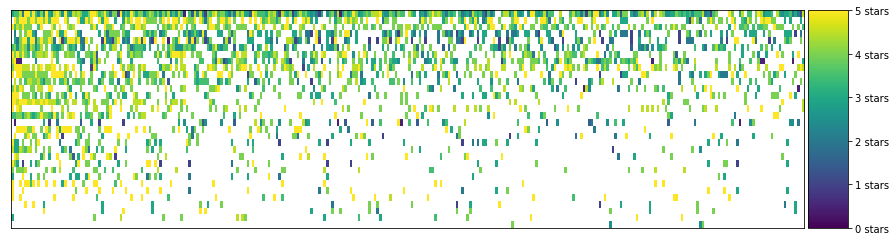

In [70]:
# TODO: Pick a cluster ID from the clusters above
cluster_number = 4

# Let's filter to only see the region of the dataset with the most number of values 
n_users = 75
n_movies = 300
cluster = clustered[clustered.group == cluster_number].drop(['index', 'group'], axis=1)

cluster = sort_by_rating_density(cluster, n_movies, n_users)
draw_movies_heatmap(cluster, axis_labels=False)

In [71]:
cluster.fillna('').head()

,"Shawshank Redemption, The (1994)",Forrest Gump (1994),"Silence of the Lambs, The (1991)","Matrix, The (1999)",Pulp Fiction (1994),Star Wars: Episode IV - A New Hope (1977),Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981),Terminator 2: Judgment Day (1991),Star Wars: Episode VI - Return of the Jedi (1983),Jurassic Park (1993),...,V for Vendetta (2006),Spirited Away (Sen to Chihiro no kamikakushi) (2001),Mars Attacks! (1996),Cliffhanger (1993),When Harry Met Sally... (1989),Scary Movie 2 (2001),"Birdcage, The (1996)","Amelie (Fabuleux destin d'Amélie Poulain, Le) (2001)",Back to the Future Part II (1989),"Pan's Labyrinth (Laberinto del fauno, El) (2006)"
11,3.0,3.5,3.5,4.5,2.0,5.0,5.0,3.5,5.0,3.5,...,3.0,2.5,3.0,3.0,3.5,2.0,3.0,2.0,1.0,4.5
9,,5.0,4.0,5.0,5.0,5.0,4.0,5.0,5.0,4.0,...,,,3.0,,3.0,,,,3.0,
21,5.0,3.5,4.5,4.0,5.0,4.0,4.0,4.0,,,...,4.0,4.0,,,,4.0,,4.0,,3.5
3,,2.0,,4.0,,4.0,5.0,5.0,3.0,2.0,...,,,3.0,3.0,3.0,,1.0,,2.0,
31,,3.0,2.0,4.0,5.0,5.0,3.0,5.0,5.0,2.0,...,,,4.0,3.0,4.0,,,,4.0,


In [74]:
# TODO: Fill in the name of the column/movie. e.g. 'Forrest Gump (1994)'
# Pick a movie from the table above since we're looking at a subset
movie_name = 'Toy Story (1995)'

cluster[movie_name].mean()

3.75

Recommendation

In [75]:
# The average rating of 20 movies as rated by the users in the cluster
cluster.mean().head(20)

Shawshank Redemption, The (1994)                                                  4.380952
Forrest Gump (1994)                                                               3.925000
Silence of the Lambs, The (1991)                                                  3.850000
Matrix, The (1999)                                                                4.300000
Pulp Fiction (1994)                                                               4.184211
Star Wars: Episode IV - A New Hope (1977)                                         4.368421
Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)    4.205882
Terminator 2: Judgment Day (1991)                                                 4.088235
Star Wars: Episode VI - Return of the Jedi (1983)                                 4.294118
Jurassic Park (1993)                                                              3.468750
Braveheart (1995)                                                                 4.187500

In [76]:
cluster.fillna('').head()

,"Shawshank Redemption, The (1994)",Forrest Gump (1994),"Silence of the Lambs, The (1991)","Matrix, The (1999)",Pulp Fiction (1994),Star Wars: Episode IV - A New Hope (1977),Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981),Terminator 2: Judgment Day (1991),Star Wars: Episode VI - Return of the Jedi (1983),Jurassic Park (1993),...,V for Vendetta (2006),Spirited Away (Sen to Chihiro no kamikakushi) (2001),Mars Attacks! (1996),Cliffhanger (1993),When Harry Met Sally... (1989),Scary Movie 2 (2001),"Birdcage, The (1996)","Amelie (Fabuleux destin d'Amélie Poulain, Le) (2001)",Back to the Future Part II (1989),"Pan's Labyrinth (Laberinto del fauno, El) (2006)"
11,3.0,3.5,3.5,4.5,2.0,5.0,5.0,3.5,5.0,3.5,...,3.0,2.5,3.0,3.0,3.5,2.0,3.0,2.0,1.0,4.5
9,,5.0,4.0,5.0,5.0,5.0,4.0,5.0,5.0,4.0,...,,,3.0,,3.0,,,,3.0,
21,5.0,3.5,4.5,4.0,5.0,4.0,4.0,4.0,,,...,4.0,4.0,,,,4.0,,4.0,,3.5
3,,2.0,,4.0,,4.0,5.0,5.0,3.0,2.0,...,,,3.0,3.0,3.0,,1.0,,2.0,
31,,3.0,2.0,4.0,5.0,5.0,3.0,5.0,5.0,2.0,...,,,4.0,3.0,4.0,,,,4.0,


In [77]:
user_id = 7

# Get all this user's ratings
user_2_ratings  = cluster.loc[user_id, :]
user_2_ratings

Shawshank Redemption, The (1994)                        NaN
Forrest Gump (1994)                                     NaN
Silence of the Lambs, The (1991)                        5.0
Matrix, The (1999)                                      5.0
Pulp Fiction (1994)                                     5.0
                                                       ... 
Scary Movie 2 (2001)                                    NaN
Birdcage, The (1996)                                    NaN
Amelie (Fabuleux destin d'Amélie Poulain, Le) (2001)    NaN
Back to the Future Part II (1989)                       NaN
Pan's Labyrinth (Laberinto del fauno, El) (2006)        NaN
Name: 7, Length: 300, dtype: float64

In [78]:
# TODO: Pick a user ID from the dataset
# Look at the table above outputted by the command "cluster.fillna('').head()" 
# and pick one of the user ids (the first column in the table)
user_id = 7

# Get all this user's ratings
user_2_ratings  = cluster.loc[user_id, :]

# Which movies did they not rate? (We don't want to recommend movies they've already rated)
user_2_unrated_movies =  user_2_ratings[user_2_ratings.isnull()]

# What are the ratings of these movies the user did not rate?
avg_ratings = pd.concat([user_2_unrated_movies, cluster.mean()], axis=1, join='inner').loc[:,0]

# Let's sort by rating so the highest rated movies are presented first
avg_ratings.sort_values(ascending=False)[:20]

Fight Club (1999)                                            4.500000
Inception (2010)                                             4.500000
Dark Knight, The (2008)                                      4.454545
Casablanca (1942)                                            4.416667
Shawshank Redemption, The (1994)                             4.380952
Mad Max: Fury Road (2015)                                    4.357143
Deadpool (2016)                                              4.357143
Rear Window (1954)                                           4.357143
300 (2007)                                                   4.333333
Pirates of the Caribbean: At World's End (2007)              4.312500
Interstellar (2014)                                          4.312500
Apocalypse Now (1979)                                        4.285714
Ratatouille (2007)                                           4.285714
Good Will Hunting (1997)                                     4.277778
Edge of Tomorrow (20